## Importing Modules

In [1]:
import tensorflow as tf
import ampligraph
import numpy as np
import pandas as pd

In [2]:
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score

In [3]:
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

In [19]:
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.utils import save_model, restore_model
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score
from ampligraph.evaluation import mrr_score
from ampligraph.evaluation import hits_at_n_score
from ampligraph.evaluation import select_best_model_ranking

In [69]:
from ampligraph.discovery import query_topn
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from ampligraph.discovery import discover_facts
from ampligraph.utils import create_tensorboard_visualizations

In [5]:
print("Ampligraph version : {}".format(ampligraph.__version__))

Ampligraph version : 1.4.0


In [6]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.15.5


# Loading the KG (Knowledge Graph) dataset -

A standard KG called **Freebase-15k-237** will be loaded. You can load KGs, csvs, ntriples etc from the API : https://docs.ampligraph.org/en/1.4.0/ampligraph.datasets.html

* FB15k-237 dataset : Freebase knowledge base (ontology behind Google's semantic search feature (knowledge graph) which is a backend for Google search results that include structured asnwers to querues instead of series of links to external resources.) Its is 1.9 billion triples in the format (rfd - resource description format). Google bought it in 2010.IN 2016 it was closed and was migrated to Wikidata. FB15k-237 is a link prediction dataset created from FB15k. While FB15k consists of 1,345 relations, 14,951 entities, and 592,213 triples, many triples are inverses that cause leakage from the training to testing and validation splits. FB15k-237 was created by Toutanova and Chen (2015) to ensure that the testing and evaluation datasets do not have inverse relation test leakage. In summary, FB15k-237 dataset contains 310,079 triples with 14,505 entities and 237 relation types.

https://paperswithcode.com/dataset/fb15k-237

* wn18rr dataset : WN18RR is a link prediction dataset created from WN18, which is a subset of WordNet. WN18 consists of 18 relations and 40,943 entities. However, many text triples are obtained by inverting triples from the training set. Thus the WN18RR dataset is created to ensure that the evaluation dataset does not have inverse relation test leakage. In summary, WN18RR dataset contains 93,003 triples with 40,943 entities and 11 relation types.

https://paperswithcode.com/dataset/wn18rr

* yago3 : YAGO3-10 is benchmark dataset for knowledge base completion. It is a subset of YAGO3 (which itself is an extension of YAGO) that contains entities associated with at least ten different relations. In total, YAGO3-10 has 123,182 entities and 37 relations, and most of the triples describe attributes of persons such as citizenship, gender, and profession.

https://paperswithcode.com/dataset/yago3-10

* DBpedia: It extracts factual information from Wikipedia pages, allowing users to find answers to questions where the information is spread across multiple Wikipedia articles. Data is accessed using an SQL-like query language for RDF called SPARQL.

https://www.dbpedia.org/

* Wikidata : 

https://developer.ibm.com/articles/use-wikidata-in-ai-and-cognitive-applications-pt1/

https://developer.ibm.com/articles/use-wikidata-in-ai-and-cognitive-applications-pt2/

For this exercise we have remapped the IDs of freebase 237 and created a csv file containing human readable names instead of IDs.

In [7]:
URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header = None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(3)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark


One example -

['academy award for best writing adapted screenplay',
        '/award/award_category/nominees./award/award_nomination/nominated_for',
        'the graduate']]

In [8]:
print('Total triples in the KG: ', dataset.shape)

Total triples in the KG:  (310079, 3)


# Creating training, validation and test splits

We will use train_test_split_no_unseen(). This API ensures that the test and validation splits contain triples whose entities are "seen" during training . This API can be used to generate train/test splits such that test set contains only entities 'seen' during training

In [10]:
# Validation set of size 500

test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed = 0)

# Test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed = 0)

print('Total triples: ', dataset.shape)
print('Size of train: ', X_train.shape)
print('Size of valid: ', X_valid.shape)
print('Size of test: ', X_test.shape)

Total triples:  (310079, 3)
Size of train:  (308579, 3)
Size of valid:  (500, 3)
Size of test:  (1000, 3)


# Model Training

Knowledge Graph embeddings are learned by training a neural architecture over a graph. In the training phase there is a loss function **L** that includes a scoring function **fm(t)** which is a model specific function that assigns a score to a triple **t = (sub, pred, obj)**

https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html

a) **TransE** :  
It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. The scoring function computes a similarity between the embedding of the subject translated by the embedding of the predicate and embedding of the object using L1 or L2 norm ||.||

                            f = −||s + p − o||n
                            
Translation Embeddings for modeling multi-relational data : https://proceedings.neurips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf


In [20]:
model = TransE(k = 150,                                                          # embedding size
              epochs = 100,                                                      # num epochs
              batches_count = 10,                                                # num batches
              eta = 1,                                                           # num of corruptions to generate during training
              loss = 'pairwise', loss_params = {'margin': 1},                    #  loss type and it's hyperparameters
              initializer = 'xavier', initializer_params = {'uniform': False},
              regularizer = 'LP', regularizer_params = {'lambda': 0.001, 'p': 3},
              optimizer = 'adam', optimizer_params = {'lr': 0.001},
              seed = 0, verbose = True)

In [22]:
model.fit(X_train)

save_model(model, 'TransE-small.pkl')

Average TransE Loss:   0.013576: 100%|████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/epoch]


# Compute the evaluation metrics-

Per Triple metrics : This is a metric that is computed for each test triple.

### Score : 
This is the value asigned to a triple, by the model, by applying the scoring function

In order to interpret the score we have two options -

1. We can create a list of hypothesis that we want to test, score them and then choose the top n hypothesis as True statements.
2. Here unlike classification task, we are doing a learning to rank task. So, here we can generate the corruptions and compare the triple score against the scores of corruptions to see how well does the model rank the test triple against them

In [26]:
test_triple = ['harrison ford',
              '/film/actor/film./film/performance/film',
              'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest: \n', test_triple)
print('Triple Score: \n', triple_score)

Triple of interest: 
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score: 
 [-8.3477955]


In [34]:
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman', 'kristen bell', 'mark hamill', 'neil patrick harris', 'harrison ford', ]

# Stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_actors,
                             ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                             ['star wars'] * len(list_of_actors)])
hypothesis

array([['salma hayek', '/film/actor/film./film/performance/film',
        'star wars'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars'],
       ['natalie portman', '/film/actor/film./film/performance/film',
        'star wars'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars'],
       ['harrison ford', '/film/actor/film./film/performance/film',
        'star wars']], dtype='<U39')

In [35]:
triple_scores = model.predict(hypothesis)

In [36]:
# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-8.2549305'],
       ['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-8.3477955'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-9.087776'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars', '-9.221671'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-9.350438'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-9.354377'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-9.367626']], dtype='<U39')

### Rank
For a triple, this metric is computed by generating corruptions and then scoring them and computing the rank(position) of the triple score against the corruptions. 

##### Step - 1 : Compute the score of the test triple
The entire process should run in a loop which is -

for each test set triple <s, p, o>:
           
           a. Compute the score of the test triple (hypothesis) 
               hypothesis_score = score(<s, p, o>)

           b. Generate the subject corruptions 
                   sub_corr = <?, p, o>
           c. Compute the score of the subject corruptions
                   sub_corr_score = score(sub_corr) 
           d. Find the position of hypothesis_score in sub_corr_score to get the sub_rank

           e. Generate the object corruption 
                   obj_corr = <s, p, ?>
           f. Compute the score of the object corruptions
                   obj_corr_score = score(obj_corr) 
           g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank

           h. Return rank = [sub_rank, obj_rank]

In [37]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest: \n', test_triple)
print('Triple Score: \n', triple_score)

Triple of interest: 
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score: 
 [-8.3477955]


##### Step - 2 : Generate the Subject Corruptions and compute rank
sub_corr = <?, p, o>

In [38]:
print('The number of unique entities: ', len(model.ent_to_idx))

The number of unique entities:  14184


In [42]:
subj_corr = np.column_stack([list(model.ent_to_idx.keys()),
                            [test_triple[1]] * len(model.ent_to_idx),
                            [test_triple[2]] * len(model.ent_to_idx)])

In [50]:
subj_corr

array([['/m/011xg5', '/film/actor/film./film/performance/film',
        'star wars'],
       ['/m/011yd2', '/film/actor/film./film/performance/film',
        'star wars'],
       ['/m/011yxg', '/film/actor/film./film/performance/film',
        'star wars'],
       ...,
       ['zoology', '/film/actor/film./film/performance/film',
        'star wars'],
       ['zurich', '/film/actor/film./film/performance/film', 'star wars'],
       ['zz top', '/film/actor/film./film/performance/film', 'star wars']],
      dtype='<U107')

In [56]:
len(subj_corr)

14184

In [51]:
sub_corr_score = model.predict(subj_corr)

Now that we have a score, let us compute the rank as follows -

COUNT(Corruption_score >= Triple_score)

Find the position of the hypothesis score (triple score) in sub_corr_score to get the SUB_RANK

In [54]:
sub_rank_worst = np.sum(np.greater_equal(sub_corr_score, triple_score[0])) + 1
print('Assigning the worst rank (to break ties):', sub_rank_worst)

Assigning the worst rank (to break ties): 1529


##### Step - 3 : Generate the Object Corruptions and compute rank

obj_corr = <s, p, ?>

In [55]:
obj_corr =  np.column_stack([
                [test_triple[0]] * len(model.ent_to_idx),
                [test_triple[1]] * len(model.ent_to_idx), 
                list(model.ent_to_idx.keys())])

print('Object corruptions:\n', obj_corr)
print('\nSize of object corruptions:\n', obj_corr.shape)

Object corruptions:
 [['harrison ford' '/film/actor/film./film/performance/film' '/m/011xg5']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yd2']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yxg']
 ...
 ['harrison ford' '/film/actor/film./film/performance/film' 'zoology']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zurich']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zz top']]

Size of object corruptions:
 (14184, 3)


In [57]:
# Compute the score of the object corruptions
obj_corr_score = model.predict(obj_corr)

In [59]:
# Find the position of hypothesis_score in obj_corr_score to get the obj_rank
obj_rank_worst = np.sum(np.greater_equal(obj_corr_score, triple_score[0])) + 1
print('Assigning the worst rank (to break ties):', obj_rank_worst)

Assigning the worst rank (to break ties): 832


In [60]:
print('Subject corruption rank:', sub_rank_worst)
print('Object corruption rank:', obj_rank_worst)

Subject corruption rank: 1529
Object corruption rank: 832


### Computing the (Unfiltered) rank using evaluate_performance API

By default, evaluate_performance API computes the unfiltered ranls i.e. if any True positives are present in corruptions, they will not be removed before ranking. However, usually for evaluation we follow a filtered evaluation

In [62]:
ranks = evaluate_performance(np.array([test_triple]),
                            model = model,
                            ranking_strategy = 'worst')

print('\n Ranks: ', ranks)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


 Ranks:  [[1529  832]]


###### Multiple strategies to compute rank when there are ties

Assume there are only 10 corruptions, and assume that all corruptions get the same score as the test triple. The ranks are as follows -

* Assign the **worst rank**, i.e. the test set triple gets a rank of 11. This is the strictest. This is used in ampligraph by default

rank=COUNT(corruptionscore≥hypothesisscore)  + 1

* **Middle Rank**,   the test set triple gets a rank of 6. Refer paper (ICLR 2020) : https://openreview.net/pdf?id=BkxSmlBFvr

rank=COUNT(corruptionscore>hypothesisscore)+COUNT(corruptionscore==hypothesisscore)/2  + 1

* **Best Rank**,  the test set triple gets a rank of 1. This approach is followed by ConvKB paper https://arxiv.org/pdf/1712.02121.pdf

rank=COUNT(corruptionscore>hypothesisscore)  + 1

### Filtered Evaluation - 

Previously while evaluating, we generate all the corruptions (using all unique entities in our datasets) per test triple, score and rank them. While doing so we are not filtering the true posiives (i.e. some corruptions may not really be corruptions and may be ground truth triples observed during training.) Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. 

To filter out the True Positives (after generating subject corruptions and after generating object corruptions). one can pass all the True Positive triples to filter_triples parameter of the evaluate_performance API. This will perform a "filtered" evaluation and return the "filtered" ranks adjusted by removing the True Positives from the corruptions.

In [12]:
print('Size of X_test: ', X_test.shape)

Size of X_test:  (1000, 3)


In [13]:
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

In [15]:
ranks = evaluate_performance(np.array([test_triple]),
                            model = model,
                            filter_triples = X_filter)
print(ranks)

One obvious question is why do we append the Valid and Test set to the X_filter. The model has not "observed" them during training. We do so because, we would like to evaluate a test triple against it's corruptions and not against known facts. If we know that the Validation triples and Test triples are facts (and not queries), we need to filter these triples out of the generated corruptions. This is the standard procedure that is used to compute the metrics to compete on the leadership board.

### Aggregate Metrics

Once we have the ranks for all the test set triples, we can compute the following aggregate metrics :
* MR
* MRR
* Hits@N

These metrics indicate the overall quality of the model on a test set. These metrics come from Information Retrieval domain and are always computed on a set of True Statements.
Let's do it with an example -

In [67]:
X_test_small = np.array(
                [['doctorate',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'computer engineering'],
                 ['star wars',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],
                 ['harry potter and the chamber of secrets',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],
                 ['star wars', '/film/film/language', 'english language'],
                 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
                ])
X_test_small

array([['doctorate',
        '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
        'computer engineering'],
       ['star wars',
        '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
        'united states dollar'],
       ['harry potter and the chamber of secrets',
        '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
        'united states dollar'],
       ['star wars', '/film/film/language', 'english language'],
       ['harrison ford', '/film/actor/film./film/performance/film',
        'star wars']], dtype='<U95')

In [69]:
len(X_train)

308579

In [70]:
len(X_valid)

500

In [71]:
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test_small,
                            model = model,
                            filter_triples = X_filter,
                            corrupt_side = 's,o')
print(ranks)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.80it/s]


[[   8    9]
 [   1    1]
 [ 109    1]
 [   1    1]
 [1518  822]]


#### Mean Rank (MR) : 
It is the average of all the ranks of the triples. The value ranges from 1 (ideal case when all ranks equal to 1) to number of corruptions (where all the ranks are last).

In [73]:
print('MR :', mr_score(ranks))

MR : 247.1


#### Mean Reciprocal Rank (MRR) : 
It is the average of the reciprocal ranks of all the triples. The value ranges from 0 to 1; higher the value better is the model.
MRR is an indicator of mean rank after removing the effect of outliers.

In [75]:
print('MRR :', mrr_score(ranks))

MRR : 0.5247160729578209


In [76]:
print('Mean rank after removing the outlier effect: ', np.ceil(1/mrr_score(ranks)))

Mean rank after removing the outlier effect:  2.0


#### Hits@n
It is the percentage of computed ranks that are greater than (in terms of ranking) or equal to a rank of n. The value ranges from 0 to 1; higher the value better is the model.

In [78]:
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))

hits@1 : 0.5
hits@10 : 0.7


In [79]:
# print unique entities
print('Number of unique entities:', len(model.ent_to_idx))

Number of unique entities: 14184


What if, for a model, you observe that on a test set, the MRR score is 0.01? Is it a good model?

It is not very straightforward. What the above value means is that if you remove the outlier effect, on an average the ranks are around 100 (1/0.01). It may be a good/bad value. It depends on number of corruptions that you have used for the computation. Say you had 1 million corruptions and yet the mrr score was 0.01. The model, in general, was quite good at ranking against 1 million corruption because on an average it gave a rank of close to 100. But say if the corruptions were only 100 and we had an mrr of 0.01, it means that the model did a very bad task at ranking the test triples against just 100 corruptions.

On a real life dataset, on should take a closer look at hits@n values and decide whether the model is a good model or not. The choice of n should depend on the number of corruptions that are being generated per test triple. If a large percentage of ranks computed on the test set triple falls within the n ranks, then the model can be considered as a good model.

In [18]:
def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

In [81]:
display_aggregate_metrics(ranks)

Mean Rank: 247.1
Mean Reciprocal Rank: 0.5247160729578209
Hits@1: 0.5
Hits@10: 0.7
Hits@100: 0.7


# Training with Early Stopping 

While training a model, we would like to make sure that the model does not overfit or under fit on the data. If we train a model for a fixed number of epochs, we will not know whether the model has underfit or overfit the training data. Hence it is necessary to test the model performance on a held out set at regular intervals to decide when to stop training. This is called "Early stopping", i.e. we don't let the model run for a long time but stop much before when the performance on the held out set starts to degrade.

However we also do not want to model to overfit on the held out set and limit the generalization capabilities of the model. Hence we should create both a validation set and a test set to verify the generalization capability of the model, and to make sure that we dont over fit and under fit on the data.

In [82]:
early_stopping_params = { 'x_valid': X_valid,   # Validation set on which early stopping will be performed
                          'criteria': 'mrr',    # metric to watch during early stopping
                          'burn_in': 150,       # Burn in time, i.e. early stopping checks will not be performed till 150 epochs
                          'check_interval': 50, # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
                          'stop_interval': 2,   # If the monitored criteria degrades for these many epochs, the training stops. 
                          'corrupt_side':'s,o'  # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
                        }

# Create a TransE model as earlier -

model = TransE(k = 100,
              epochs = 10000,
              eta = 1,
              loss = 'multiclass_nll',
              initializer = 'xavier', initializer_params = {'uniform': False},
              regularizer = 'LP', regularizer_params = {'lambda': 0.0001, 'p': 3},
              optimizer = 'adam', optimizer_params = {'lr': 0.001},
              seed = 0, batches_count = 1, verbose = True)

model.fit(X_train, 
         early_stopping = True,
         early_stopping_params = early_stopping_params)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


Average TransE Loss:   0.014648 — Best validation (mrr): 0.095652:   8%|▌     | 849/10000 [14:14<2:33:35,  1.01s/epoch]


In [84]:
save_model(model, 'TransE-early-stopping.pkl')

In [85]:
# evaluate the model with filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)
# display the metrics
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 45.05it/s]


Mean Rank: 506.239
Mean Reciprocal Rank: 0.16526740494343775
Hits@1: 0.101
Hits@10: 0.288
Hits@100: 0.5945


# Practical Evaluation Protocols

These standard protocols with the KG with millions of entities are not feasible. So, there are some practical methods -

### Evaluating by corrupting specific sides -

Say our test set is made up of triples of type <movie, film_language, language_category> and we want to find if our model can correctly find the language of the movie.

In [86]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['the mummy returns', '/film/film/language', 'english language'],
       ['love affair', '/film/film/language', 'english language'],
       ['vicky cristina barcelona', '/film/film/language',
        'spanish language'],
       ['borat', '/film/film/language', 'english language'],
       ['/m/03gyvwg', '/film/film/language', 'japanese language'],
       ['and the band played on', '/film/film/language',
        'english language'],
       ['/m/09gb_4p', '/film/film/language', 'english language'],
       ['from russia with love', '/film/film/language',
        'turkish language'],
       ['titanic', '/film/film/language', 'italian language'],
       ['salt', '/film/film/language', 'english language'],
       ['superman ii', '/film/film/language', 'english language'],
       ['spy game', '/film/film/language', 'english language']],
      dtype=object)

In [87]:
ranks = evaluate_performance(X_test_movie_languages, model = model, filter_triples = X_filter)
display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.23it/s]


Mean Rank: 375.9166666666667
Mean Reciprocal Rank: 0.2604060555937539
Hits@1: 0.16666666666666666
Hits@10: 0.4166666666666667
Hits@100: 0.6666666666666666

Size of test set: (12, 3)
Size of ranks: (12, 2)


Some types of corruption - 

* s for subject corruption only
* o for object corruption only
* s+o for subject and object corruption. Returns a single rank.
* s,o for subject and object corruption separately (default). Returns 2 ranks. This is equivalent to calling evaluate_performance twice with s and o.

As here we want to find if the model can correctly find the language of the movie, we will corrupt the object side of the thing.


In [88]:
ranks = evaluate_performance(X_test_movie_languages, 
                            model = model,
                            filter_triples = X_filter,
                            corrupt_side = 'o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 36.23it/s]


Mean Rank: 220.33333333333334
Mean Reciprocal Rank: 0.34339267265349743
Hits@1: 0.25
Hits@10: 0.5
Hits@100: 0.9166666666666666

Size of test set: (12, 3)
Size of ranks: (12,)


### Evaluating against a subset of entities

Depending on the use case or size of the graph, you may want to evaluate the test set by generating corruptions only from a subset of entities.
For example, let's say we are doing a genetic study using KG. The graph may have different entity types like patient, diseases, genes, mutations, co-morbidities,ect. Say we want to find out what mutations cause disease i.e. **< ?, causes, disease_name>**. For this use case it doesnt make sense to replace the placeholder with all the entities. A logical replacement would be by using all the mutations.

Similarly for our use case, we are interested in finding the language of the movie. So it makes sense to use only language categories to generate the corruptions for the object side. It also makes the task easier for the model.

In [91]:
print('The number of corruptions generated per test triple is:', len(model.ent_to_idx))

The number of corruptions generated per triple is: 14184


In [92]:
unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

Number of languages in KG: 61

 {'irish', 'filipino language', 'french', 'thai language', 'yue chinese', 'bengali language', 'france', 'mandarin chinese', 'indonesian language', 'turkish language', 'tamil language', 'finnish language', 'japanese language', 'tagalog language', 'latin language', 'serbo-croatian language', 'standard chinese', 'polish language', 'german language', 'persian language', 'punjabi language', 'vietnamese language', 'chinese language', 'spanish language', 'croatian language', 'korean language', 'hebrew language', 'dutch language', 'greek language', 'cantonese', 'yiddish language', 'czech language', 'russian language', 'germany', 'ukrainian language', 'afrikaans language', 'malay language', 'italian language', 'arabic language', 'sinhala language', 'danish language', 'bulgarian language', 'albanian language', 'swedish language', 'hindi language', 'swahili language', 'italian food', 'serbian language', 'romanian language', 'norwegian language', 'urdu language', 'kh

Now let's create the corruptions only on these languages using entities_subset 

In [94]:
ranks = evaluate_performance(X_test_movie_languages,
                            model = model,
                            filter_triples = X_filter,
                            corrupt_side = 'o',
                            entities_subset = list(unique_languages))
display_aggregate_metrics(ranks)

F:\github_repos\ml-engineering\graph_models\ampligraph_env\lib\site-packages\ampligraph\latent_features\models\EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.20it/s]


Mean Rank: 13.083333333333334
Mean Reciprocal Rank: 0.3456077061340219
Hits@1: 0.25
Hits@10: 0.5
Hits@100: 1.0


Usually, we can see a drastic increase in the metric values mainly because we are using fewer semantically "valid" corruptions.

When we have a schema for our KG, and the focus is not just graph completion but a specific use case (Eg: similar job search, product recommendation, gene discovery to target a disease, etc), we would recommend using semantically "valid" corruptions by looking at the schema to do performance evaluation.

# Comparison of Models -

a) **TransE** :  
It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. The scoring function computes a similarity between the embedding of the subject translated by the embedding of the predicate and embedding of the object using L1 or L2 norm ||.||

                            f = −||s + p − o||n
                            
Translation Embeddings for modeling multi-relational data : https://proceedings.neurips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf

In [97]:
model_transe = TransE(k=150, epochs=50, eta=1, loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

model_transe.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model_transe,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.43it/s]


Mean Rank: 980.5485
Mean Reciprocal Rank: 0.12330816247577198
Hits@1: 0.072
Hits@10: 0.2175
Hits@100: 0.5065


In [101]:
print('The number of unique entities:', len(model_transe.ent_to_idx))
print('The number of unique relations:', len(model_transe.rel_to_idx))
print('Size of entity embeddings:', model_transe.ent_emb.shape)
print('Size of entity embeddings:', model_transe.rel_emb.shape)

The number of unique entities: 14184
The number of unique relations: 237
Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


b) **DistMult** :

This model is similar to TransE. Instead of additive operations, it does multiplication of vectors to compute the score. DistMult also has same number of parameters as TransE. This model is quite bad at differenciating anti-symmetric relations (especially during knowledge discovery), because <s,p,o> and <o,p,s> would get the same score.
https://arxiv.org/pdf/1412.6575.pdf

                                    f = ∑s ∗ p ∗ o 

Example: < Jack Likes VideoGames > < VideoGames Likes Jack >

In [100]:
model_dismult = DistMult(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model_dismult.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model_dismult,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.11it/s]


Mean Rank: 712.517
Mean Reciprocal Rank: 0.2271655415355942
Hits@1: 0.1575
Hits@10: 0.3545
Hits@100: 0.587


In [102]:
print('Size of entity embeddings:', model_dismult.ent_emb.shape)
print('Size of entity embeddings:', model_dismult.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


c) **Complex** : 

This model can be thought of as performing DistMult like operations but in Complex space. The number of parameters is twice as that of TransE and DistMult (k for real part and k for imaginary part). The scoring function can handle symmetry and anti-symmetry quite well.

In [ ]:
model_complex = ComplEx(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model_complex.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model_complex,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


Average ComplEx Loss:   0.688253:  62%|███████████████████████████▉                 | 31/50 [38:14<10:25, 32.95s/epoch]

In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

### Convolutional Models

These are convolutional models. They converts embeddings to an "image" like representation, and performs convolutions on them. Instead of embedding vectors(for s, p and o) as inputs to the model, you can think of the inputs to be like a 2 or 3-channel image where each channel represents s, p and o features.

Both models are similar in terms of their architecture, that is while extracting feature representation of inputs; but the main difference lies in the way in which the corruptions are generated and how the loss is computed.

d) **ConvKB** : ConvKB generates eta corruptions per training triple and **computes feature matrix for the triples/corruptions (s,p,o)** using shared layers. It uses margin based losses like other KGE models. https://aclanthology.org/N18-2053/

In [ ]:
model = ConvKB(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, 
                batches_count= 5, # Goes OOM (ResourceExhaustedError) if batch count is 1
                verbose=True)


model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

e) **ConvE** : ConvE on the other hand does a "target" prediction. It uses s and p embeddings and tries to predict all the o's (multi-hot encoding) in the graph. In one way, it is equivalent to treating all the unknown entities during training as a negative. Due to this approach, one needs to use the standard "target-based" losses for training ConvE models.

The output layer of ConvE is extremely huge (since it is equal to the number of unique entities in the graph), which in turn results in scalability issues when working with practical graphs.
https://arxiv.org/abs/1707.01476

In [ ]:
model = ConvE(k=150, epochs=2, loss='bce', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 20, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

In [ ]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

# Hyperparameter Selection
A large value of k may result in overfitting, and the size of the embeddings on the disk would also be large. It may also happen that the embedding matrix may not even fit on the GPU. A small k may result in underfitting. Ideally, you should choose a k which is large enough, along with a proper choice of eta.

It has been observed that the performance of model increases with increase in eta up to a certain point and then saturates. Usually a good value for eta is between 20-30.

In [16]:
model = TransE(k=250, epochs=20, eta=20, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)

In [20]:
ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
display_aggregate_metrics(ranks)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.25it/s]


Mean Rank: 582.305
Mean Reciprocal Rank: 0.15423522010888976
Hits@1: 0.09
Hits@10: 0.29
Hits@100: 0.585


### Grid Search and Random Search -

Ampligraph provides an API to perform model selection and to run experimental campaigns on datasets. One can use select_best_model_ranking to perform model selection. It supports grid search and random search.

In [21]:
model_class = TransE
param_grid = {
                     "batches_count": [5],
                     "seed": 0,
                     "epochs": [50],
                     "k": [150, 50],
                     "eta": [1, 5],
                     "loss": ["multiclass_nll"],
                     "loss_params": {},
                     "embedding_model_params": {},
                     "regularizer": ["LP"],
                     "regularizer_params": {
                         "p": [3],
                         "lambda": [1e-3]
                      },
                     "optimizer": ["adam"],
                     "optimizer_params":{
                         "lr": 0.001 #lambda: np.random.uniform(0.00001, 0.01)
                     },
                     "verbose": False
                 }
best_model, best_params, best_mrr_train, ranks_test, mrr_test, experimental_history = \
        select_best_model_ranking(model_class, 
                          X_train, 
                          X_valid, 
                          X_test, 
                          param_grid,
                          # max_combinations=2, # performs random search-executes 2 models by randomly choosing params
                          use_filter=True, 
                          verbose=True,
                          early_stopping=True)

4it [07:31, 112.99s/it]


In [22]:
print('MRR of the best model:', best_mrr_train)

MRR of the best model: 0.1798454611096679


In [23]:
# params of the best model
best_params

{'batches_count': 5,
 'seed': 0,
 'epochs': 50,
 'k': 150,
 'eta': 1,
 'loss': 'multiclass_nll',
 'regularizer': 'LP',
 'optimizer': 'adam',
 'verbose': False,
 'optimizer_params': {'lr': 0.001},
 'regularizer_params': {'p': 3, 'lambda': 0.001}}

In [24]:
experimental_history

[{'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 50,
   'k': 150,
   'eta': 1,
   'loss': 'multiclass_nll',
   'regularizer': 'LP',
   'optimizer': 'adam',
   'verbose': False,
   'optimizer_params': {'lr': 0.001},
   'regularizer_params': {'p': 3, 'lambda': 0.001}},
  'results': {'mrr': 0.1798454611096679,
   'mr': 495.323,
   'hits_1': 0.117,
   'hits_3': 0.195,
   'hits_10': 0.304}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 50,
   'k': 150,
   'eta': 5,
   'loss': 'multiclass_nll',
   'regularizer': 'LP',
   'optimizer': 'adam',
   'verbose': False,
   'optimizer_params': {'lr': 0.001},
   'regularizer_params': {'p': 3, 'lambda': 0.001}},
  'results': {'mrr': 0.1763783598505391,
   'mr': 514.976,
   'hits_1': 0.109,
   'hits_3': 0.193,
   'hits_10': 0.315}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 50,
   'k': 50,
   'eta': 1,
   'loss': 'm

# Model Calibrarion

Models usually return a score between +inf and -inf (depending on the type). These scores can be calibrated to the range using model.calibrate. 
As described earlier, model.predict returns a score which doesn't signify anything because the score is not bound for most of the models. It is just a value and to interpret it we use the ranking protocol.

However, one can also calibrate the scores of a model, so that one can get a bounded confidence estimate which ranges from 0 to 1. This is done by performing a logistic regression on the score of triples. One can use the calibrate API to do this. It takes an argument X_Pos which should be True Positives (Eg. training set). If a list of True Negatives are available, then this can be passed to X_Neg. The model would calibrate the scores by tuning a logistic regressor. One can then use predict_proba API to get a bounded score.

If a list of True Negatives are not available, then the calibration can be performed on synthetic corruptions. However, while doing so, one must pass the positive_base_rate argument which specifies the base rate of positive statements. Choosing this value is a challenging task and it affects the value predicted by predict_proba.

https://arxiv.org/abs/1912.10000

In [25]:
model = restore_model('TransE-early-stopping.pkl')
X_test_small = np.array([['star wars', '/film/film/language', 'english language'],
                         ['star wars', '/film/film/language', 'java']]) 

model.predict(X_test_small)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


array([ -5.2896194, -13.296273 ], dtype=float32)

In [27]:
len(X_train)

308579

In [28]:
model.calibrate(X_train, 
                X_neg = None, 
                positive_base_rate = 0.5, 
                batches_count = 100, 
                epochs = 100)

Calibration Loss:   0.211596: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78epoch/s]


In [29]:
model.predict_proba(X_test_small)

array([0.98566324, 0.19533403], dtype=float32)

# Knowledge Discovery

To perform knowledge discovery using graph embeddings.

* query_topn : Given two elements of a triple will return the top_n results of all possible completions ordered by predicted score.

* discover_facts : generate a set of candidate statements using one of several defined strategies and return triples that perform well when evaluated against corruptions.

* find_clusters : perform link-based cluster analysis on graph embeddings

* find_duplicates : which will find duplicate entities in a graph based on their embeddings

### Triple Completion

Sometimes you may have either a relation and entity (head or tail) pair, or just two entities, and you want to see what the top n results returned by the model are that completes the triple.

<head, relation, ?> 
    <head, ?,        tail>
    <?,    relation, tail>

In [31]:
model = restore_model('TransE-early-stopping.pkl')

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [38]:
triples, scores = query_topn(model, top_n = 10,
                            head = 'albert einstein',
                            relation = '/people/person/profession',
                            tail = None,
                            ents_to_consider = None,
                            rels_to_consider = None)
# Specify rels_to_consider or ents_to_consider lists to return triples where the missing element is filled only from that list.

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -5.243964672088623 	 ['albert einstein' '/people/person/profession' 'scientist'] 
Score: -5.803171157836914 	 ['albert einstein' '/people/person/profession' 'astronomer'] 
Score: -5.838274002075195 	 ['albert einstein' '/people/person/profession' 'economist'] 
Score: -5.885437965393066 	 ['albert einstein' '/people/person/profession' 'physicist'] 
Score: -6.215908050537109 	 ['albert einstein' '/people/person/profession' 'poet'] 
Score: -6.259941577911377 	 ['albert einstein' '/people/person/profession' 'professor'] 
Score: -6.313385963439941 	 ['albert einstein' '/people/person/profession' 'author'] 
Score: -6.3817338943481445 	 ['albert einstein' '/people/person/profession' 'politician'] 
Score: -6.5500898361206055 	 ['albert einstein' '/people/person/profession' 'cartoonist'] 
Score: -6.704334735870361 	 ['albert einstein' '/people/person/profession' 'military officer'] 


In [39]:
triples, scores = query_topn(model, top_n=10, 
                             head='the departed', 
                             relation=None, 
                             tail='/m/086k8', 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -7.161651611328125 	 ['the departed' '/film/film/production_companies' '/m/086k8'] 
Score: -7.693564414978027 	 ['the departed' '/film/film/produced_by' '/m/086k8'] 
Score: -7.796206951141357 	 ['the departed' '/film/film/written_by' '/m/086k8'] 
Score: -7.943090438842773 	 ['the departed'
 '/award/award_winning_work/awards_won./award/award_honor/award_winner'
 '/m/086k8'] 
Score: -8.213024139404297 	 ['the departed' '/film/film/film_production_design_by' '/m/086k8'] 
Score: -8.374640464782715 	 ['the departed' '/film/film/edited_by' '/m/086k8'] 
Score: -8.46765422821045 	 ['the departed' '/film/film/film_art_direction_by' '/m/086k8'] 
Score: -8.596135139465332 	 ['the departed' '/film/film/executive_produced_by' '/m/086k8'] 
Score: -8.78531551361084 	 ['the departed' '/film/film/story_by' '/m/086k8'] 
Score: -9.155117988586426 	 ['the departed' '/film/film/costume_design_by' '/m/086k8'] 


### Clustering

Once the model is trained, we can use the embeddings and perform downstream tasks like clustering or classification. Here we will illustrate how to do node clustering. Ampligraph provides an api find_clusters which takes in model, the concepts to cluster, and the clustering model (sklearn based). It performs clustering and returns the cluster indices for the concepts.

In [41]:
# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('Size of the subset being used for subset generation:', len(all_entities))

Size of the subset being used for subset generation: 14184


In [42]:
all_entities

array(['torquay united', 'showgirls', 'tampa bay lightning', ...,
       'houssine kharja', 'julia roberts', 'george gordon byron'],
      dtype='<U107')

In [43]:
# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

In [44]:
# call find_clusters to get the cluster assignments of the entities

# Clustering mode. Choose from:

#     - | 'entity' (default): the algorithm will cluster the embeddings of the provided entities.
#     - | 'relation': the algorithm will cluster the embeddings of the provided relations.
#     - | 'triple' : the algorithm will cluster the concatenation
#         of the embeddings of the subject, predicate and object for each triple.
        
        
clusters = find_clusters(all_entities, model, kmeans, mode='entity')

In [46]:
len(clusters)

14184

In [47]:
set(clusters)

{0, 1, 2}

Now that we have the cluster assignments, let us plot it in a 2d space. Let us use PCA to reduce the dimensions of the embeddings from k=150 to 2 dimensions.

In [50]:
# Get the embeddings (100 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='entity')

In [52]:
jobs_embeddings.shape

(14184, 100)

In [53]:
# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

In [55]:
embeddings_2d.shape

(14184, 2)

In [56]:
# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

In [58]:
df.head()

,entities,clusters,embedding1,embedding2
0,torquay united,cluster0,-0.525961,-0.085825
1,showgirls,cluster1,0.269621,-0.582940
2,tampa bay lightning,cluster1,0.357866,-0.256318
3,cheaper by the dozen,cluster1,0.272679,-0.512488
4,crash,cluster0,-0.313980,-0.397362


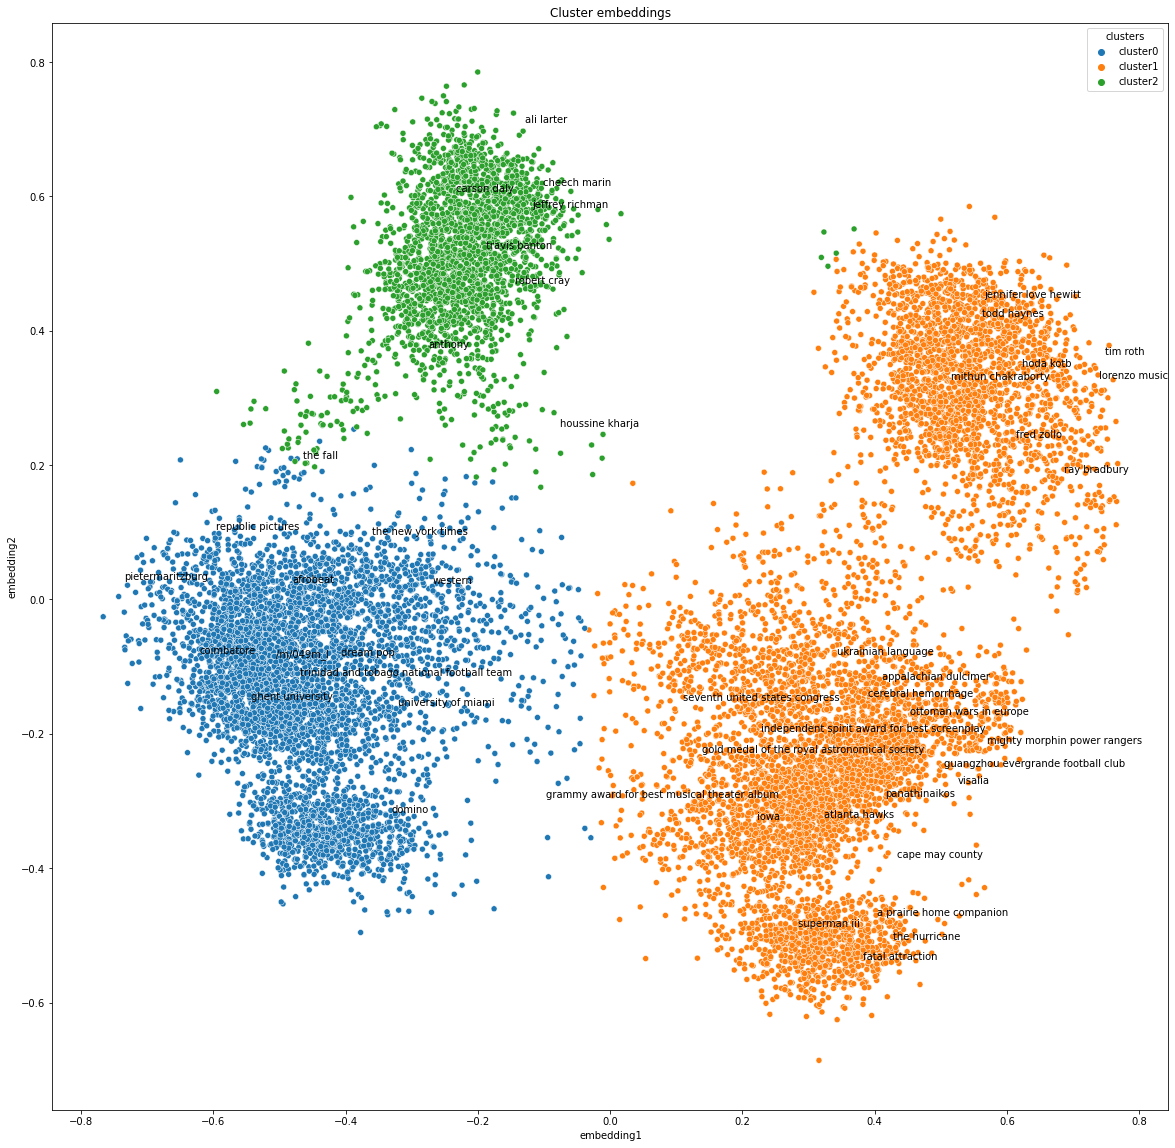

In [63]:
plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text
texts = []
for i, point in df.iterrows():
    # randomly choose a few labels to be printed
    if np.random.uniform() < 0.003:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
        
adjust_text(texts)
plt.show()

### Hypothesis Generation

Other times you may wish to discover any potential new facts from an existing knowledge graph.

With a knowledge graph containing millions of entities the space of possible facts is huge, and evaluating all of them can take a very long time. In order to speed up this task we have implemented a number of sampling strategies.

The strategies implemented include:

entity_frequency, graph_degree, cluster_coefficient, cluster_triangles, cluster_squares, random_uniform, exhaustive.

Entities in all strategies excluding random_uniform, exhaustive are sorted in ascending fashion, on the assumption that frequent or densely connected entities are less likely to have missing true statements.

The general procedure is to generate a set of candidate statements, and then rank them against a set of corruptions using the ampligraph.evaluation.evaluate_performance() function.

A sampling weight is calculated for each entity using the specified strategy, and max_candidates are sampled to produce the candidate triple set.

Candidates are then evaluated to obtain a rank, and triples that appear in the top_n ranked statements of evaluation procedure are returned as potentially true statements.

In [67]:
triples, ranks = discover_facts(dataset.values, 
                                model, 
                                top_n=500, 
                                max_candidates=500, 
                                strategy='cluster_triangles', 
                                target_rel='/people/person/profession', 
                                seed=42)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 35.43it/s]


Rank: 10.5 	 ['bob clampett' '/people/person/profession' 'actor'] 
Rank: 287.5 	 ['bob boyle' '/people/person/profession' 'actor'] 
Rank: 353.0 	 ['thomas newman' '/people/person/profession' 'actor'] 


#### Running models on GPU

Sometime while running the model, you may run into ResourceExhausted error on the GPU, especially because the batches may not fit in memory. This can usually be solved by increasing the batch count.

There are times when you may have millions of entities in the graph, and you may not be able to allocate the embedding matrix on the GPU. In this case, you can use the large graph mode. It gets activated automatically when number of entities is >500000. You can also use set_entity_threshold and change this threshold manually.

from ampligraph.latent_features import set_entity_threshold

set_entity_threshold(100000)

...

In this mode, ampligraph creates the embedding matrix on the CPU and loads only the embeddings of the entities of the batch being trained on the GPU. This mode is much faster than training just on CPU as it can use the GPU cores to speed up computations. More details can be found in the link.